# MODIS Land Cover Mapping and Geospatial Visualization

This Python script handles the extraction and visualization of land cover data from a satellite dataset, specifically MODIS data, over a specified region. The dataset is loaded using `xarray`, and geographic coordinates are assigned to the data. The land cover information is visualized using `matplotlib` and `cartopy`, with custom color maps for better distinction of land cover classes. Additionally, geospatial data such as cities and roads are plotted over the land cover map to provide contextual information.

### Key Steps:
1. **Dataset Loading and Processing**: 
   - The satellite dataset is loaded using `xarray` and coordinates for latitude and longitude are assigned.
   - A bounding box for a region of interest is defined to subset the dataset.

2. **Land Cover Classification**:
   - A dictionary is created to map land cover classes to descriptive names.
   - Custom colors are defined for each land cover class, and a colormap is generated.

3. **Data Filtering**:
   - The land cover classes to be visualized are filtered, and a new colormap and normalization are applied for plotting.

4. **Map Visualization**:
   - The filtered land cover data is plotted over a geographical map using `cartopy` with custom legends and annotations.
   - Geospatial features like cities and roads are overlayed on the map for better contextualization.

### Output:
The final output is a geographical map showing filtered land cover data along with overlays of cities, roads, and optionally urban areas.

### Customization:
You can adjust the bounding box for different regions, select different land cover classes for visualization, and modify the map features (e.g., roads, cities) based on available shapefiles.


In [ ]:
# Importing necessary libraries for data handling, visualization, and geographic mapping.
# xarray is used for handling and analyzing labeled multi-dimensional arrays (common for scientific datasets).
import xarray as xr
# matplotlib.pyplot is used for creating static, animated, and interactive visualizations.
import matplotlib.pyplot as plt
# cartopy.crs is a module for working with cartographic projections and map visualizations.
import cartopy.crs as ccrs
# numpy is used for numerical operations and array manipulations.
import numpy as np
# geopandas extends pandas to handle geospatial data and perform operations on geographic shapes.
import geopandas as gpd
# matplotlib.colors provides tools to define and manipulate colormaps for visualizations.
import matplotlib.colors as mcolors
# cartopy.feature is used to add geographic features, like coastlines and borders, to maps.
import cartopy.feature as cfeature
# ListedColormap allows the creation of custom colormaps for visualizations.
from matplotlib.colors import ListedColormap
# matplotlib.ticker provides tools to customize tick marks and labels in plots.
import matplotlib.ticker as mticker

In [ ]:
# Open the dataset
# Load the satellite dataset (e.g., MODIS data) using xarray. The dataset is in HDF format, 
# so the "netcdf4" engine is specified to handle the file correctly.
ds = xr.open_dataset('../Auxiliary Data/MCD12C1.A2020001.061.2022172062638.hdf', engine="netcdf4")


# Sort the Y-axis in descending order
ds = ds.sortby("YDim:MOD12C1", ascending=False)

# Generate latitude and longitude arrays
# Create a latitude array with values ranging from -90 to 90, evenly spaced for 3600 points.
# This corresponds to the number of points along the YDim:MOD12C1 dimension of the dataset.
latitude = np.linspace(-90, 90, 3600)  # For YDim:MOD12C1

# Create a longitude array with values ranging from -180 to 180, evenly spaced for 7200 points.
# This corresponds to the number of points along the XDim:MOD12C1 dimension of the dataset.
longitude = np.linspace(-180, 180, 7200)  # For XDim:MOD12C1

# Assign latitude and longitude as coordinates with explicit dimensions
# Use the `assign_coords` method to add the generated latitude and longitude arrays
# as coordinates to the dataset. The "latitude" array is tied to the YDim:MOD12C1 dimension,
# and the "longitude" array is tied to the XDim:MOD12C1 dimension.
ds = ds.assign_coords({
    "latitude": ("YDim:MOD12C1", latitude), 
    "longitude": ("XDim:MOD12C1", longitude)
})

# Replace the existing dimensions with the newly assigned coordinates
# The `swap_dims` method is used to replace the YDim:MOD12C1 dimension with "latitude"
# and the XDim:MOD12C1 dimension with "longitude". This makes the dataset directly indexable
# using latitude and longitude values instead of the original dimension labels.
ds = ds.swap_dims({"YDim:MOD12C1": "latitude", "XDim:MOD12C1": "longitude"})

In [ ]:
# Define the bounding box coordinates for a region of interest
# These coordinates specify the minimum and maximum longitude (minlon, maxlon)
# and latitude (minlat, maxlat) for the region you want to extract from the dataset.

# Box 1: The bounding box covers a specific region in the Amazon area
minlon, maxlon, minlat, maxlat = -72, -48, -11, -3  # Example box 1

# Uncomment the following lines to use different bounding box coordinates:

# Box 2: Another region of interest with a different bounding box
#minlon, maxlon, minlat, maxlat = -58, -56, -18, -16  # Example box 2

# Box 3: A smaller bounding box in the Amazon region
#minlon, maxlon, minlat, maxlat = -57, -54, -9, -6  # Amazon small box

# Select the subset of the dataset corresponding to the defined bounding box
# Use the `sel` method to slice the dataset along the latitude and longitude dimensions.
# - `latitude`: Slice the data between the minimum and maximum latitude (`minlat` to `maxlat`).
#   Note that latitude values are usually in descending order (from 90 to -90).
# - `longitude`: Slice the data between the minimum and maximum longitude (`minlon` to `maxlon`).
#   Longitude values are typically in ascending order (from -180 to 180).

ds_subset = ds.sel(
    latitude=slice(minlat, maxlat),  # Latitude slicing (descending order)
    longitude=slice(minlon, maxlon)  # Longitude slicing (ascending order)
)

# The resulting `ds_subset` contains only the data within the specified bounding box,
# making it more manageable for region-specific analysis.

In [ ]:
# Define the land cover classes and their corresponding descriptive names
# Each key in the dictionary represents a class number, and its value is the name of the land cover type.
land_cover_classes = {
    0: "Water",
    1: "Evergreen Needleleaf Forest",
    2: "Evergreen Broadleaf Forest",
    3: "Deciduous Needleleaf Forest",
    4: "Deciduous Broadleaf Forest",
    5: "Mixed Forests",
    6: "Closed Shrubland",
    7: "Open Shrublands",
    8: "Woody Savannas",
    9: "Savannas",
    10: "Grasslands",
    11: "Permanent Wetlands",
    12: "Croplands",
    13: "Urban and Built-Up",
    14: "Cropland/Natural Vegetation Mosaic",
    15: "Snow and Ice",
    16: "Barren or Sparsely Vegetated",
}

# Define a list of custom colors corresponding to the land cover classes
# These colors will be used in the plot to represent each class visually.
custom_colors = [
    "blue",         # 0: Water
    "darkgreen",    # 1: Evergreen Needleleaf Forest
    "limegreen",    # 2: Evergreen Broadleaf Forest
    "yellowgreen",  # 3: Deciduous Needleleaf Forest
    "olivedrab",    # 4: Deciduous Broadleaf Forest
    "olive",        # 5: Mixed Forests
    "brown",        # 6: Closed Shrubland
    "peru",         # 7: Open Shrublands
    "tan",          # 8: Woody Savannas
    "khaki",        # 9: Savannas
    "gold",         # 10: Grasslands
    "aqua",         # 11: Permanent Wetlands
    "orange",       # 12: Croplands
    "red",          # 13: Urban and Built-Up
    "teal",         # 14: Cropland/Natural Vegetation Mosaic
    "white",        # 15: Snow and Ice
    "gray"          # 16: Barren or Sparsely Vegetated
]

# Create a colormap using the custom colors
# The colormap maps the land cover classes to the corresponding colors for visualization.
custom_cmap = ListedColormap(custom_colors)

# Define a normalization that maps class numbers to colors in the colormap
# BoundaryNorm ensures the colors align correctly with the class boundaries.
num_classes = len(land_cover_classes)  # Total number of land cover classes
cmap = custom_cmap
norm = mcolors.BoundaryNorm(
    boundaries=np.arange(-0.5, len(custom_colors) + 0.5, 1),  # Boundaries between classes
    ncolors=len(custom_colors)  # Total number of colors
)

# Define the classes that appear on the map (optional)
# This is useful if not all classes are present in the region being plotted.
active_classes = [0, 2, 4, 5, 8, 9, 10, 11, 12, 13]  # Example subset of active classes

# Filter the land cover classes to include only the active classes
# This creates a smaller dictionary with just the classes that are present.
filtered_land_cover_classes = {k: land_cover_classes[k] for k in active_classes}
print(filtered_land_cover_classes)

# Filter the colors to match the active classes
# This ensures that the colormap contains only the colors for the active classes.
filtered_colors = [custom_colors[k] for k in active_classes]
print(filtered_colors)

# Create a new colormap using the filtered colors
# The new colormap will include only the colors corresponding to the active classes.
filtered_cmap = ListedColormap(filtered_colors)
print(filtered_cmap)

# Update the normalization to match the filtered classes
# This ensures that the color mapping aligns with the filtered colormap.
norm2 = mcolors.BoundaryNorm(
    boundaries=np.arange(0, len(filtered_colors), 1),  # Adjust boundaries to the filtered classes
    ncolors=len(filtered_colors)  # Total number of filtered colors
)

In [ ]:
# Plot the land cover data
fig, ax = plt.subplots(figsize=(10, 3.5))

# Plot the land cover data on the map
# Use the filtered colormap and normalization
plot = ds_subset["Majority_Land_Cover_Type_1"].plot(
    ax=ax,
    x="longitude",
    y="latitude",
    cmap=filtered_cmap,  # Use the filtered colormap
    norm=norm2,          # Use the filtered normalization
    add_colorbar=False,  # Suppress the default colorbar
    zorder=1             # Layering of the plot
)

# Create custom legend handles for filtered classes
handles = [
    plt.Line2D(
        [0], [0],                       # Dummy line for legend
        color=filtered_colors[i],       # Color of the class
        lw=4,                           # Line width for better visibility
        label=f"{cls}: {filtered_land_cover_classes[cls]}"  # Class label
    )
    for i, cls in enumerate(active_classes)  # Loop through filtered classes
]

# Add the legend to the plot
ax.legend(
    handles=handles,                 # Custom handles
    loc="lower left",                # Position of the legend
    bbox_to_anchor=(1.05, 0.2),      # Positioning outside the main plot
    title="Land Cover Types",        # Legend title
    fontsize=6,                      # Font size for labels
    title_fontsize=10,               # Font size for title
    frameon=False                    # Disable legend box frame
)

# Set plot title and axis labels
ax.set_title("Filtered Land Cover Map", fontsize=14)  # Title
ax.set_xlabel("Longitude")                            # X-axis label
ax.set_ylabel("Latitude")                             # Y-axis label

# Adjust layout to fit everything nicely
plt.tight_layout()

# Show the plot
plt.show()

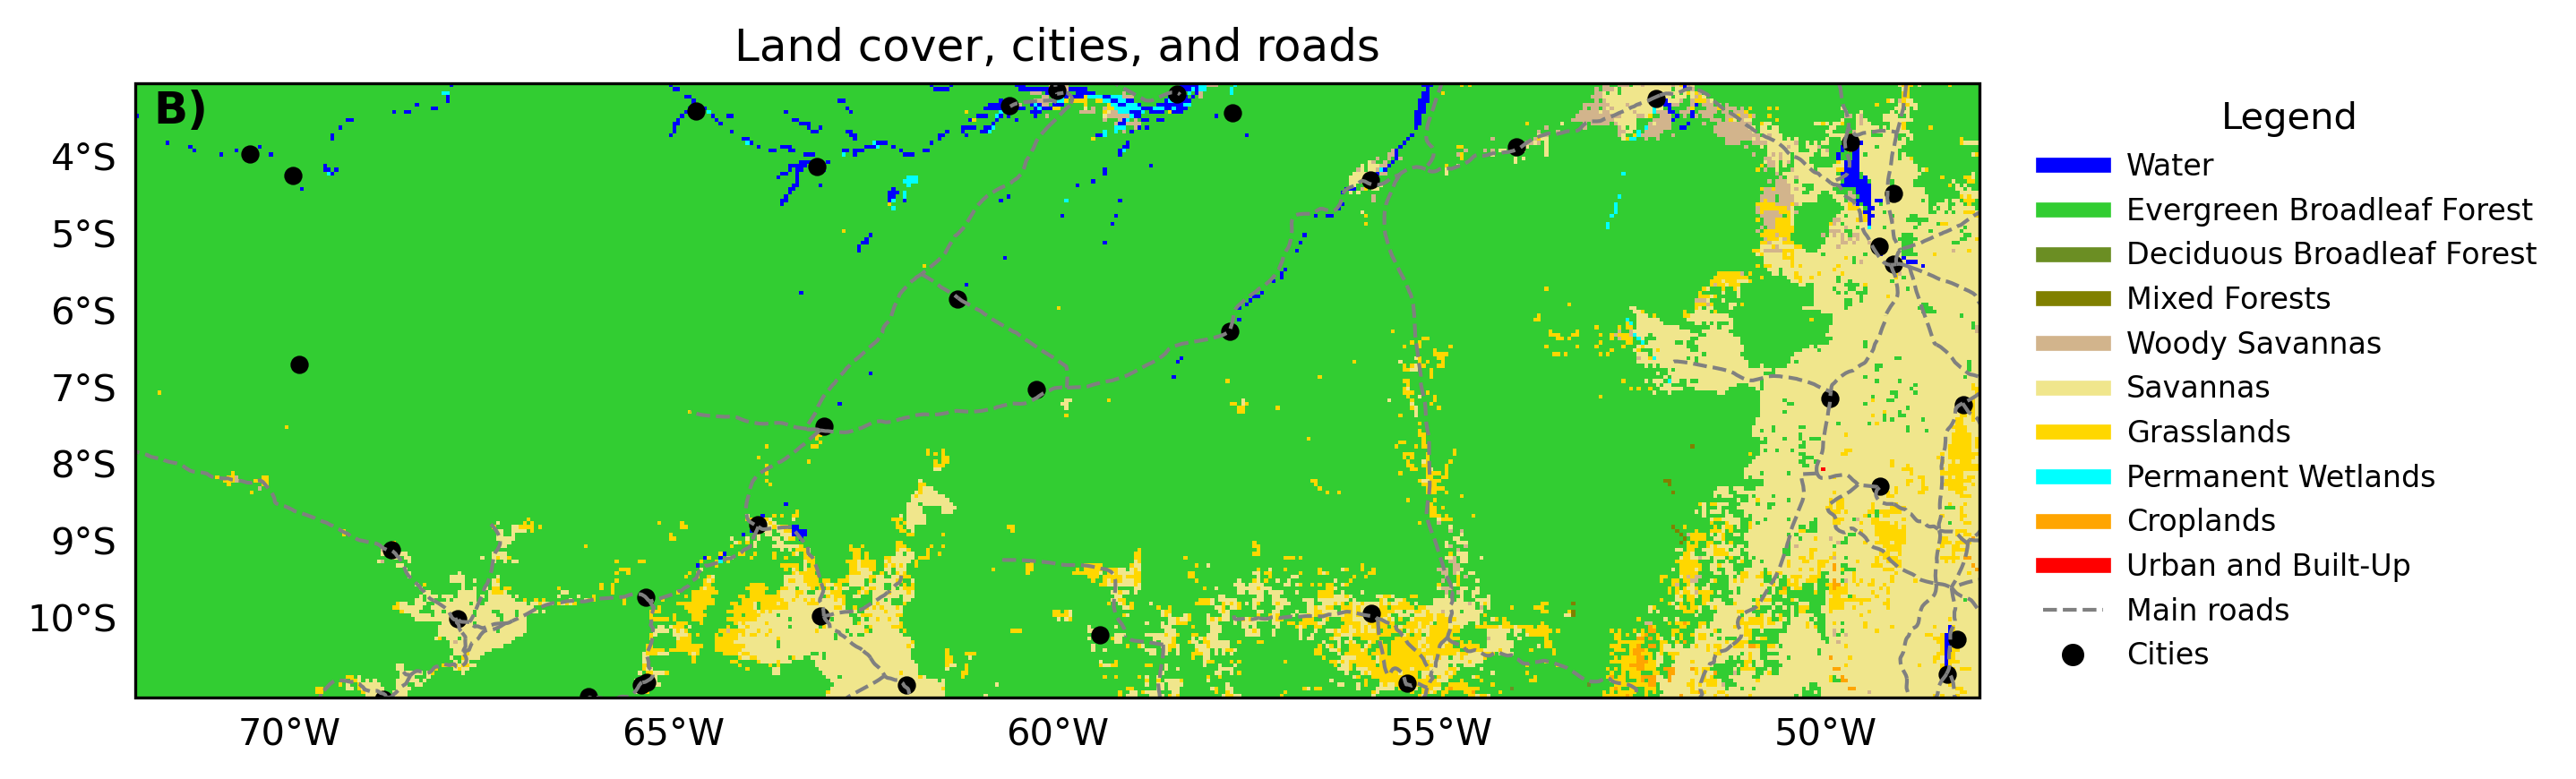

In [21]:
# Define the file paths for shapefiles that contain geographical data
cities_shapefile = "../Auxiliary Data/ne_10m_populated_places.shp"  # Cities shapefile
roads_shapefile = "../Auxiliary Data/ne_10m_roads.shp"  # Roads shapefile

# Read the shapefiles for cities, roads, and urban areas into GeoDataFrames
cities = gpd.read_file(cities_shapefile)
roads = gpd.read_file(roads_shapefile)

# Create a figure and axis with a specified map projection (PlateCarree)
fig = plt.figure(figsize=(10, 3), dpi=300)  # Set figure size and resolution
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())  # Define axis with projection

# Map limits
# Set the map extent based on the predefined latitude and longitude bounds
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())  # Define map's region

# Add main roadas
# Plot the main roads (from shapefile) on the map with custom line style
roads.plot(ax=ax, transform=ccrs.PlateCarree(), color="gray", linestyle="--", linewidth=1.0, label="Main roads")

# Add cities
# Scatter plot cities with specific formatting on the map
ax.scatter(
    cities.geometry.x, cities.geometry.y,  # X and Y coordinates of cities
    color="black", s=15,  # Color black and set size for city points
    transform=ccrs.PlateCarree(),  # Specify projection for the city points
    label="Cities"  # Label for the legend
)


# Add gridlines with labels
gl = ax.gridlines(draw_labels=True)  # Add gridlines to the map
gl.top_labels = gl.right_labels = False  # Disable labels at the top and right of the map
gl.bottom_labels = gl.left_labels = True  # Enable labels at the bottom and left
gl.xlines = False  # Hide the vertical gridlines
gl.ylines = False  # Hide the horizontal gridlines

# Customize the gridline intervals
gl.xlocator = mticker.MultipleLocator(5)  # Longitude labels every 5 degrees
gl.ylocator = mticker.MultipleLocator(1)  # Latitude labels every 1 degree

# Plot the land cover data on the map
plot = ds_subset["Majority_Land_Cover_Type_1"].plot(
    ax=ax,
    x="longitude",  # X-axis (longitude) for the land cover data
    y="latitude",  # Y-axis (latitude) for the land cover data
    cmap=cmap,  # Colormap for the land cover data
    norm=norm,  # Normalization for the colormap
    add_colorbar=False,  # Disable colorbar since it's not needed in this case
    zorder=0,  # Set the z-order for layering (land cover data in the background)
)

# Create custom legend handles for land cover types
# These handles represent the different filtered land cover classes in the legend
handles = [
    plt.Line2D([0], [0], color=filtered_colors[i], lw=4, label=f"{filtered_land_cover_classes[cls]}")
    for i, cls in enumerate(active_classes)  # Iterate over the active land cover classes
]

# Add additional handles for the other map features (roads, cities)
additional_handles = [
    plt.Line2D([0], [0], color="gray", lw=1.0, linestyle="--", label="Main roads"),
    plt.Line2D([0], [0], color="black", marker="o", markersize=5, linestyle="", label="Cities")
]

# Combine the legend handles for all map features
handles.extend(additional_handles)

# Add the legend to the plot
ax.legend(
    handles=handles,  # Use the combined list of handles for the legend
    loc="lower left",  # Position the legend at the bottom left
    bbox_to_anchor=(1.02, 0),  # Position the legend outside the plot to the right
    title="Legend",  # Set the title for the legend
    fontsize=8,  # Set the font size for the legend text
    title_fontsize=10,  # Set the font size for the legend title
    frameon=False  # Disable the border around the legend
)

# Add bold text to the upper-left corner of the map
ax.text(
    0.01, 0.99,  # Relative position in axes coordinates (0=left/bottom, 1=right/top)
    'B)',  # Text content
    transform=ax.transAxes,  # Use axes-relative coordinates for positioning
    fontsize=12,  # Set font size for the annotation
    fontweight='bold',  # Make the text bold
    ha='left',  # Horizontal alignment to the left
    va='top',  # Vertical alignment to the top
)

# Set the title for the plot
plt.title("Land cover, cities, and roads")  # Set title text

# Adjust the layout to prevent overlap of plot elements
plt.tight_layout()

# Save the plot to a PNG file
#plt.savefig('filename.png')

# Display the plot
plt.show()